<a href="https://colab.research.google.com/github/shreddy1/NLP/blob/master/Assignment_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn import metrics

import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Embedding
from keras.layers import Activation, Conv1D, GlobalMaxPooling1D
from keras import optimizers


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Calculating Accuracy, Recall, Precision, and Figure-of-Merit (f-1) score.
#Taken help from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

#Calculates Recall
def rec(true_label, predicted_label):
    true_positives = K.sum(K.round(K.clip(true_label * predicted_label, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(true_label, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Calculates Precision
def prec(true_label, predicted_label):
    true_positives = K.sum(K.round(K.clip(true_label * predicted_label, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predicted_label, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Calculates f-1 score
def f1_score(true_label, predicted_label):
    precision = prec(true_label, predicted_label)
    recall = rec(true_label, predicted_label)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
link= "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
movie=movie= pd.read_csv(link,sep='\t')

In [0]:
print("Movie: ", movie.shape)
movie.head()

Movie:  (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
# #dropping unnecessary columns
# movie= movies.drop(['PhraseId','SentenceId'],axis=1)
# movie.head()

In [0]:
result= movie.isnull()
print(result)

        PhraseId  SentenceId  Phrase  Sentiment
0          False       False   False      False
1          False       False   False      False
2          False       False   False      False
3          False       False   False      False
4          False       False   False      False
...          ...         ...     ...        ...
156055     False       False   False      False
156056     False       False   False      False
156057     False       False   False      False
156058     False       False   False      False
156059     False       False   False      False

[156060 rows x 4 columns]


In [0]:
# movie.tail()


In [0]:
len(movie.SentenceId.unique())
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [0]:
movie.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

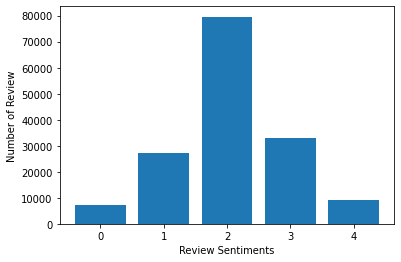

In [149]:
graph=movie.groupby('Sentiment').count()
plt.bar(graph.index.values, graph['Phrase'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [0]:
#Creating a dataset with full sentences
sentence_raw_data = movie.loc[movie.groupby('SentenceId')['PhraseId'].idxmin()]
print(sentence_raw_data)


        PhraseId  ...  Sentiment
0              1  ...          1
63            64  ...          4
81            82  ...          1
116          117  ...          3
156          157  ...          1
...          ...  ...        ...
155984    155985  ...          2
155997    155998  ...          2
156021    156022  ...          1
156031    156032  ...          1
156039    156040  ...          2

[8529 rows x 4 columns]


In [0]:
sentence_raw_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [0]:
# print(movie.Phrase[:5])

In [0]:
#NLP Process
#Here we are removing the punctuation and converting to lowercase.
import string
print('Punctuation:',string.punctuation)

# This line of code is converting all the uppercase words to lowercase
movie.Phrase=movie.Phrase.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())
print('lowercase:',movie.Phrase[:5])


Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
lowercase: 0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object


In [0]:
#Tokenize sentences
movie.Phrase=movie.Phrase.str.split(' ')

In [0]:
movie.Phrase[:5]

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object

In [0]:
#Removal of stop words
#import nltk

stop_word=stopwords.words('english')
print("Stop Words: ",stop_word,"\n")

movie.Phrase=[w for w in movie.Phrase if w not in stop_word]
movie.Phrase.head()

Stop Words:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object

In [0]:
#Text Normalization
#Stemming words

porter = PorterStemmer()
movie.Phrase=movie.Phrase.apply(lambda x: [porter.stem(w) for w in x])

#Lemmatize words
wordnet_lemmatizer = WordNetLemmatizer()
movie.Phrase=movie.Phrase.apply(lambda x: [wordnet_lemmatizer.lemmatize(w) for w in x])

# lancaster=LancasterStemmer()
# remove_stopwords = True
# useStemming = True
# useLemma = False
# removePuncs = True

In [0]:
#Features
bow_vector = CountVectorizer(ngram_range=(1,1),
                             stop_words=stop_word)

bow_vector.fit(list(sentence_raw_data['Phrase']))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
#Processing the dataset: Training & Testing 
X = np.array(sentence_raw_data['Phrase'])
Y = np.array(sentence_raw_data['Sentiment'])
# X[0], Y[0]

In [0]:
#Splitting dataset: 70% training & 30% testing
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=2003)

print("x_train:",x_train.shape)
print("x_test:",x_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)
                                                                             

x_train: (5970,)
x_test: (2559,)
y_train: (5970,)
y_test: (2559,)


In [0]:
#Vectorizer (Bag of Words Model)
A = bow_vector.transform(x_train)
#print("A:",A)
B = bow_vector.transform(x_test)
#print("B:",B)

In [0]:
#Defining the model

#Define the batch size

batch_size = 128
learning_rate = 1e-5
epochs = 10
n_class= 5
mode = "reg"
decay = 1e-3

In [0]:
bow_feature_vec = pd.DataFrame(A.toarray(), columns = bow_vector.get_feature_names())
bow_feature_vec.head()

bow_feature_vec_test = pd.DataFrame(B.toarray(), columns = bow_vector.get_feature_names())
bow_feature_vec_test.head()



fea_vec_dim = bow_feature_vec.shape[1]
print(fea_vec_dim, n_class)

x_train = bow_feature_vec.values.reshape((bow_feature_vec.shape[0], bow_feature_vec.shape[1], 1))
x_train.shape



fea_vec_test_dim = bow_feature_vec_test.shape[1]
print(fea_vec_test_dim, n_class)

x_test = bow_feature_vec_test.values.reshape((bow_feature_vec_test.shape[0], bow_feature_vec_test.shape[1], 1))
x_test.shape




15040 5
15040 5


(2559, 15040, 1)

In [0]:
#took help from: https://www.programcreek.com/python/example/93293/keras.layers.convolutional.Conv1D
#Creating CNN network
def cnn_network(feature_matrix, n_class, mode, optimizer):
  model = Sequential()
  # keras.layers.UpSampling1D(size=2)
  # model.add(Embedding(10000, 150, input_length=125))
  #model.add(SpatialDropout1D(0.2))
  model.add(Conv1D(64, kernel_size=3, padding='same',input_shape=(feature_matrix.shape[1], feature_matrix.shape[2])))
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.8))
  # model.add(Conv1D(128, kernel_size=3, padding='same'))
  # model.add(Activation('relu'))
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.8))
  model.add(Flatten())
  model.add(Activation('relu'))
  model.add(Dense(n_class, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_score, prec, rec])

  return model 

In [0]:
#Taken help from: https://keras.io/optimizers/
opti_1= optimizers.Adam(lr = learning_rate, decay = decay)
model= cnn_network(x_train,n_class,mode,opti_1)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 15040, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 15040, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7520, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7520, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7520, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 481280)            0         
_________________________________________________________________
activation_11 (Activation)   (None, 481280)           

In [0]:
accuracy_loss= model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
 - 4s - loss: 1.5735 - acc: 0.2772 - f1_score: 4.0850 - prec: 2270502479.6302 - rec: 2.0425
Epoch 2/10
 - 3s - loss: 1.5326 - acc: 0.3246 - f1_score: 3.9748 - prec: 2017162454.5126 - rec: 1.9893
Epoch 3/10
 - 3s - loss: 1.4767 - acc: 0.3655 - f1_score: 3.8709 - prec: 650720345.4250 - rec: 1.9634
Epoch 4/10
 - 3s - loss: 1.4100 - acc: 0.4176 - f1_score: 3.4687 - prec: 35.2465 - rec: 1.8594
Epoch 5/10
 - 3s - loss: 1.3320 - acc: 0.4588 - f1_score: 3.0040 - prec: 10.9956 - rec: 1.7631
Epoch 6/10
 - 3s - loss: 1.2723 - acc: 0.4858 - f1_score: 2.6304 - prec: 6.2723 - rec: 1.6807
Epoch 7/10
 - 3s - loss: 1.2077 - acc: 0.5193 - f1_score: 2.3701 - prec: 4.4648 - rec: 1.6240
Epoch 8/10
 - 3s - loss: 1.1672 - acc: 0.5363 - f1_score: 2.2061 - prec: 3.5790 - rec: 1.6020
Epoch 9/10
 - 3s - loss: 1.1222 - acc: 0.5630 - f1_score: 2.0116 - prec: 2.9184 - rec: 1.5409
Epoch 10/10
 - 3s - loss: 1.0974 - acc: 0.5610 - f1_score: 1.9339 - prec: 2.6606 - rec: 1.5248


In [0]:
def get_metrics(accuracy, f1_score, precision, recall):
  print('Accuracy: ', np.round(accuracy, 4))
  print('Precision: ', np.round(precision, 4))
  print('Recall: ', np.round(recall, 4))
  print('F1 Score: ', np.round(f1_score, 4))

In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test)
get_metrics(accuracy, f1_score, precision, recall)

2559/2559 [==============================] - 1s 332us/step
Accuracy:  0.3923
Precision:  5.8674
Recall:  1.6554
F1 Score:  2.536


dict_keys(['loss', 'acc', 'f1_score', 'prec', 'rec'])


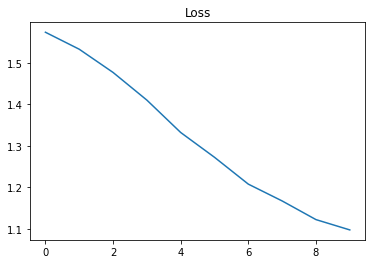

In [154]:
print(accuracy_loss.history.keys())
plt.plot(accuracy_loss.history['loss'])
plt.title('Loss')

plt.show()


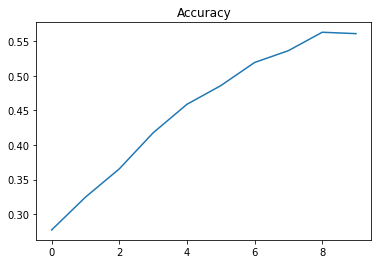

In [155]:
plt.plot(accuracy_loss.history['acc'])
plt.title('Accuracy')

plt.show()


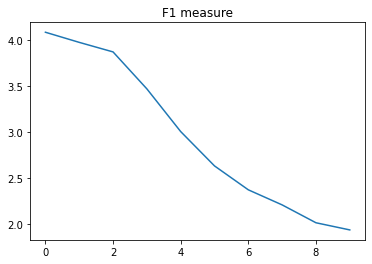

In [158]:
plt.plot(accuracy_loss.history['f1_score'])
plt.title('F1 measure')

plt.show()

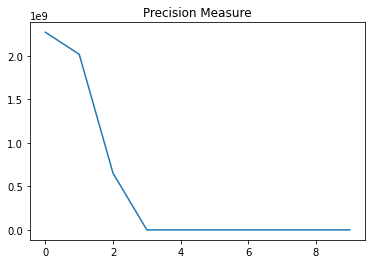

In [159]:
plt.plot(accuracy_loss.history['prec'])
plt.title('Precision Measure')

plt.show()

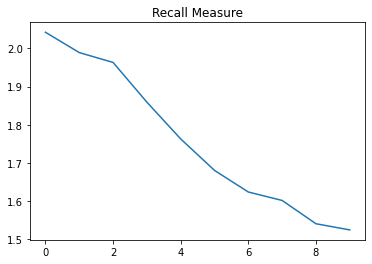

In [160]:
plt.plot(accuracy_loss.history['rec'])
plt.title('Recall Measure')

plt.show()